Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Nopphawan Nurnuansuwan"
ID = "st122410"

---

# Lab 13: Reinforcement Learning (RL)

Today we'll have a gentle introduction to reinforcement learning.
The material in today's lab comes from these references:

 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)
 - https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html
 - Reinforcement Learning: An Introduction (Sutton et al.)
 - https://github.com/werner-duvaud/muzero-general (simulator code)


## Reinforcement learning

Reinforcement Learning (RL) is a machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback on its actions and experiences.
RL uses rewards and punishment as signals for "good" and "bad" behavior.

Generally, at each step, the agent outputs an action, which is input to the environment. The environment evolves according to its dynamics, the agent observes the new state of the environment
and (optionally) a reward, and the process continues until hopefully the agent learns what behavior maximizes its reward.

<img src="img/RL.jpg" title="Introduction" style="width: 600px;" />


## Markov decision process (MDP)

A MDP is a discrete-time stochastic control process. The MDP model is based on the idea of an environment that evolves as a Markov chain.

### Markov chain

A Markov chain is a model of the dynamics of a discrete time system that obeys the (first order) "Markov property," meaning that the state $s^{t+1}$ at time
$t+1$ is conditionally independent of the state at times $0, \ldots, t-1$ given the state at time $t$, i.e.,

$$ p(s^{t+1} \mid s^t, s^{t-1}, \ldots, s^0) = p(s^{t+1} \mid s^t). $$

Informally, we might say that the current state is all you need to know to predict the next state.

More precisely, a Markov chain is defined by a set of possible states $S={s_0, s_1, \ldots, s_n}$ and a transition matrix $T(s,s')$
containing the propbabilities of state $s$ transitioning to state $s'$. Here is a visualization of a simple Markov chain:

<img src="img/RL_markov.png" title="Markov chain" style="width: 600px;" />

You might be interested in [this Markov chain simulator](https://setosa.io/ev/markov-chains/).

Now, the dynamics of the environment in a MDP are slightly different from that of a simple Markov chain. We have to consider how the agent's
actions affect the system's dynamics. At each time step, rather than just
transitioning randomly to the next state, we add the agent's action as an external input or disturbance $a \in A$, so (assuming a small number of discrete
states and actions) the transition probabilities become a 3D tensor of size $|S|\times |A|\times |S|$
mapping each state/action pair to a probability distribution over the states.

### A simple MDP

Suppose we have three states and two actions and that the state/action transition tensor is as follows:

<img src="img/RL_statetrans.png" title="" style="width: 200px;" />

To complete our simple MDP, we need a *reward function* $R$ and a *discount factor* $\gamma$. 
Suppose $R = [ 1, 0, -1 ]$ and $\gamma = 0.5$. Let's define our MDP in Python with PyTorch tensors:


In [2]:
import torch

# State transition function

T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

# Reward function

R = torch.tensor([1.,0.,-1.])

# Discount factor

gamma = 0.5

### The agent's goal

Once the MDP is defined, the agent's goal is to maximize its expected reward. If we start in state $s^0$ and perform a series
of actions $a^0, a^1, \ldots a^{T-1}$ placing us in state $s^1, s^2, \ldots s^T$, we obtain the total reward

$$ \sum_{t=0}^T \gamma^{t} R(s^t).$$

The agent's goal is to behave so as to maximize the expected total reward. To do so,
it should come up with a policy $\pi : S \times A \rightarrow \mathbb{R}$ giving a probability distribution
over actions that can be executed in each state, then when in state $s$, sample action $a$ according to that
distribution $\pi(s,\cdot)$, and repeat.

Now the agent's goal can be clearly specified as finding an optimal policy

$$ \pi^* = \textrm{argmax}_\pi \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1})}\left[ \sum_{t=0}^T \gamma^{t} R(s^t) \right]$$

Under a particular policy $\pi$, then, the *value* of state $s$ is the expected reward we obtain by following $\pi$ from state $s$:

$$ V^\pi(s) = \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1}) \mid s^0=s}\left[ R(s) + \sum_{t=1}^T \gamma^{t} R(s^t) \right]$$

The value function clearly obeys the *Bellman equations*

$$ V^\pi(s) = R(s) + \gamma \sum_{s',a'} \pi(s,a') T(s,a',s') V^\pi(s'). $$ 

### How good is a policy? Policy evaluation

To determine how good a particular policy is, we use policy evaluation.
Policy evaluation is an iterative algorithm. It starts with arbitrary values for each state
and then iteratively updates the values based on the Bellman equations until the values converge.

You can see this algorithm's pseudocode in Sutton's book on page 75.

Here we compute the value of the three states in our MDP assuming the agent always peforms the first action:

In [3]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (rewards[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

threshold = 0.0001

policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])

V = policy_evaluation(policy_optimal, T, R, gamma, threshold)
print(V)

tensor([ 1.6786,  0.6260, -0.4821])


### Policy iteration

Policy iteration starts with a random policy then uses policy evaluation and the resulting values to iteratively improve the policy until an optimal policy is obtained. It is, however,
slow, due to the policy evaluation loop within the policy iteration loop.

Here's an implementation using a slightly different formulation fo the reward as a function $R(s,a,s')$ of the current state $s$, action taken $a$, and resulting state $s'$:

In [4]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = int(policy[state].item())
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                V_temp[state] += trans_prop * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

def policy_improvement(trans_matrix, rewards, gamma):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.zeros(n_state)

    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                v_actions[action] += trans_prop * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

def policy_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(policy, trans_matrix, rewards, gamma, threshold)
        policy_improved = policy_improvement(trans_matrix, rewards, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

# Reward R(s,a,a') example

R2 = torch.tensor([[[0.1,0.,-0.2],
                    [0.2,0.,-0.1]],
                   [[0.3,0.,-0.5],
                    [0.1,0.,-0.2]],
                   [[0.2,0.,-0.1],
                    [1.,0.,-1.]]])

V_optimal, optimal_policy = policy_iteration(T, R2, gamma, threshold)
print(V_optimal)
print(optimal_policy)

tensor([0.1352, 0.2405, 0.1829])
tensor([0., 0., 0.])


### Value iteration

Value iteration is a much more efficient way to obtain the optimial policy. It calculates the value
of each state on the assumption that the agent will deterministically select the action $a$ in state $s$
that maximizes the expected reward after that. Once this value converges, the optimal policy is just
to select the best action according to that value function:

$$ V^*(s)=R(s) + \max_a \gamma \sum_{s'} T(s,a,s') V^*(s') $$

$$ \pi^*(s) = \mathrm{argmax}_a \sum_{s'} T(s, a, s') V^*(s').$$

Instead of taking the expectation (average) of values across all actions, we pick the action that achieves the maximal policy values.
As above, we use the slightly different formulation in which the reward $R(s,a,s')$ is given based on initial state, action, and resulting state:

$$ V^*(s) = \max_a \sum_{s'} T(s,a,s') [ R(s,a,s') + \gamma V^*(s')]$$
$$ \pi^* = \mathrm{argmax}_a \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma V^*(s')]$$

Here's sample code:

In [5]:
def value_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for new_state in range(n_state):
                    trans_prop = trans_matrix[state, action, new_state]
                    reward = rewards[state, action, new_state]
                    v_actions[action] += trans_prop * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

V = value_iteration(T, R2, gamma, threshold)
print(V)

tensor([0.1352, 0.2405, 0.1829])


### Exercise

Write some code now to find the optimal policy based on the values you got from value iteration above. Do you get the same result as for
policy iteration?

## OpenAI Gym

Looking at policies in matrix form is a bit difficult.

A popular simulation environment for RL is OpenAI Gym.

[OpenAI](https://openai.com) is a research company trying to develop systems exhibiting *artificial general intelligence* (AGI).
They developed Gym to support the development of RL algorithms. Gym
provides many reinforcement learning simulations and tasks. Visit [the Gym website](https://gym.openai.com) for a full list of environments.

<img src="img/RL_gym.png" title="Gym example" style="width: 600px;" />

### Installing Gym

Let's install Gym. You should do this on your local machine, not within a remote Jupyter, so that you can
see the interactive display that pops up. You can download this notebook and run it locally, or paste code
into a Python IDE, or put it in a text file and run from the command line.

In [6]:
# Do this locally, not on a remote Jupyter.

# !pip install gym

# or try

# !git clone https://github.com/openai/gym
# !cd gym
# pip install -a

### Atari games environment

Atari games includes video games such as Alien, Pong, and Space Race. Here is an example of
using the Space Invaders game. First, install the Atari simulation environment:

In [7]:
# Do this locally, not on a remote Jupyter.

# !pip install gym[atari]

Then create a Space Invaders environment:

In [8]:
import gym
#import atari_py
from gym import wrappers

#print(atari_py.list_games())

# create environment
env = gym.make('SpaceInvaders-v0')

# reset environments
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

If you render the environment locally, 
you should get output like this:

<img src="img/RL_SpaceInvaders.png" title="Space Invaders" style="width: 600px;" />

After rendering, you'll want to close the environment.

<font size="3" color="red"><b>WARNING:</b></font>
If you do work with Gym environments in Jupyter, you need to use <code><font color='red'>env.close()</font></code> after <code>env.render()</code>, or your program will get stuck.

In [9]:
# Example 1
from pyglet.gl import *

import time
env.close()
env.render()
time.sleep(5)
# close the environment
env.close()

C:\Users\THETANG\anaconda3\envs\RL39\lib\site-packages\gym\envs\atari\environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\THETANG\anaconda3\envs\RL39\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


If you cannot use Atari games due to errors occurring in Windows, you can try another simulator such as CartPole (inverted pendulum):

<img src="img/RL_CartPole.png" title="Cart pole" style="width: 600px;" />

In [10]:
# Example 2

#import gym
#import time
# create environment
#env = gym.make('CartPole-v0')

# reset environments
#env.reset()

# render the environment
#env.render()
#time.sleep(5)

#env.close()

### Running Gym in Jupyter

Before trying the example aboves, you might try these two solutions to running Gym in Jupyter notebooks:
MP4 rendering and is real-time rendering. [More information is here](https://kyso.io/eoin/openai-gym-jupyter#code=both).

#### Method 1: MP4 rendering

Here we save the simulation as an MP4 and show it at the end.
This method makes the simulation faster since there is no visualising happening every step. In this simulation we just make the space ship take a random move each step.

In [11]:
import gym
from gym import wrappers

env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

And show MP4 vdo by this code

In [12]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

#### Method 2: Show as GIF in realtime

This method is useful for look at the simulation in realtime, but it does make the simulation take longer. It does not save the gif, but if you run this cell you will see the image change as the simulation progresses.

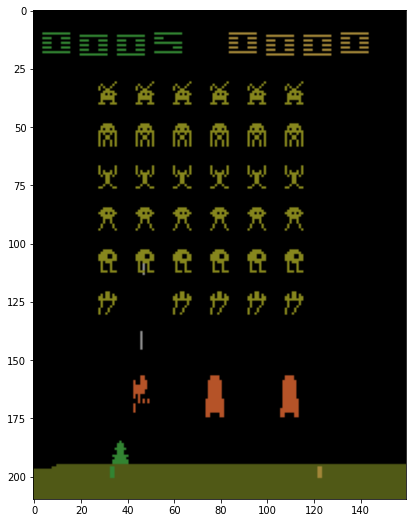

In [13]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

#### In this lab, I recommend you to use the way2 for smoother working ;-)

Take a look at the action space available, and try to get a sample from the action space:

In [14]:
print(env.action_space)
action = env.action_space.sample()
print(action)

Discrete(6)
3


Execute an action using `step()`.
The `step` method returns the next state after the action is taken.
 - **new_state**: The new observation
 - **reward**: The reward associated with that action in that state.
 - **is_done**: A flag to tell the game end (True).
 - **info**: extra information

In [15]:
new_state, reward, is_done, info = env.step(action)
print(is_done)
print(reward)
print(info)

False
0.0
{'lives': 3}


Let's make a *while* loop with a random agent:

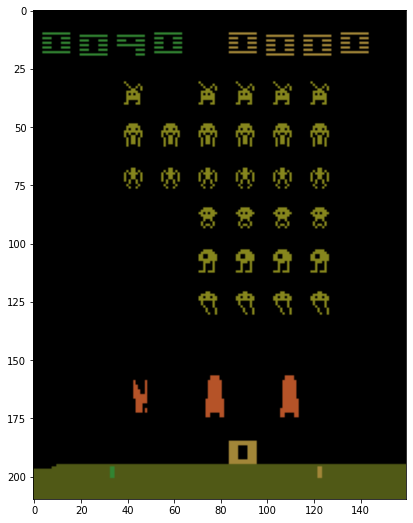

In [16]:
import time

is_done = False
env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while not is_done:
    action = env.action_space.sample()
    new_state, reward, is_done, info = env.step(action)
    print(info)
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)
env.close()

## Using the environments to do reinforcement learning

## Monte Carlo (MC) Method

Monte Carlo method is a model-free which have no require any prior knowledge of the environment. MC method is more scalable than MDP. MC control is used for finding the optimal policy when a policy is not given. There are basically two types of MC control: on-policy and off-policy. On-policy method learns about the optimal policy by executing the policy and evaluating and improving it, while off-policy methods learn about the optimal policy using information gathered using another policy (usually $\epsilon$-greedy).

## On-policy Monte Carlo control

On-policy Monte Carlo works look-a-like to policy iteration which has 2 phases: evaluation and improvement.
 - Evaluation phase: it evaluates the **action-values** (called **Q-function** $Q(s,a)$) instead of evaluates the value function.
 - Improvement phase: the policy is updated by assigning the optimal action to each stage: $\pi(s)=argmax_a Q(s,a)$

In this code below, we add **epsilon-greedy** policy which it will not exploit the best action all the time. The equations are:
 - Epsilon ($\epsilon$):

      $\pi(s,a)=\frac{\epsilon}{|A|}$  When $|A|$ is the number of all possible actions.
 - Greedy:
 
      $\pi(s,a)=1-\epsilon + \frac{\epsilon}{|A|}$

In [17]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v1')

def run_episode(env, Q, epsilon, n_action):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    # without epsilon-greedy
    # action = torch.randint(0, n_action, [1]).item()
    ##################################################
    while not is_done:
        # with epsilon-greedy
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        #######################################################
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode, epsilon):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(env.action_space.n))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            for state_action, return_t in G.items():
                state, action = state_action
                if state[0] <= 21:
                    G_sum[state_action] += return_t
                    N[state_action] += 1
                    Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
epsilon = 0.1
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode, epsilon)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  50  lose  44


## Off-policy Monte Carlo control

The Off-policy method optimizes the **target policy** ($\pi$) using data generated by another policy (**behavior policy** ($b$)).
 - Target policy: exploitation purposes, greedy with respect to its current Q-function.
 - Behavior policy: exploration purposes, generate behavior which the target policy used for learning. The behavior policy can be anything to confirm that it can explore all possibilities, then all actions and all states can be chosen with non-zero probabilities.

The weight importand for state-action pair is calculated as:

$w_t=\sum_{k=t}[\pi(a_k|s_k)/b(a_k|s_k)]$
 - $\pi(a_k|s_k)$: probabilities of taking action $a_k$ in state $s_k$
 - $b(a_k|s_k)$: probabilities under the behavior policy.

In [19]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v1')

def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

random_policy = gen_random_policy(env.action_space.n)

def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            w *= 1./ behavior_policy(state_t)[action_t]
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  39  lose  57


## Temporal Difference (TD)

Temporal Difference (TD) learning is a model-free learning algorithm like MC learning. In MC learning, Q-function is called and updated at the end of the entire episode, but TD learning update Q-function every step of an episode. One of the TD learning algorithm is Q-learning

## Q-Learning

Q-leaning is an off-policy learning algorithm. The Q-function is based on the equation:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a))$

Where
 - $\alpha$: learning rate
 - $\gamma$: discount factor
 - $\max_{a'}Q(s',a')$: greedy behavior policy, the highest Q-value among those in state $s'$ is selected to generate learning data.

We know from class that Q-learning finds the optimal greedy policy while running an epsilon-greedy policy. 

In [20]:
import importlib
from collections import defaultdict
import torch
import numpy

env_id = "SpaceInvaders-v0"
env = gym.make(env_id)

env.reset()

# defining epsilon-greedy policy
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(n_action) * epsilon / n_action
        # print(probs)
        # print(state)
        # print(Q[state])
        best_action = torch.argmax(Q[state]).item()
        if not(best_action in available_actions):
            best_action = -1
            Q_max = -800000000
            for i in range(n_action):
                if i in available_actions and Q_max < Q[state][i]:
                    Q_max = Q[state][i]
                    best_action = i
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

def q_learning(env, gamma, n_episode, alpha, player):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = 9
    Q = defaultdict(lambda: torch.zeros(n_action))
    print('start learning')
    for episode in range(n_episode):
        print("episode: ", episode + 1)
        state = env.reset()
        state = hash(tuple(state.reshape(-1)))

        is_done = False
        while not is_done:
            action = epsilon_greedy_policy(state, Q, available_actions)
            next_state, reward, is_done, info = env.step(action)
            next_state = hash(tuple(next_state.reshape(-1)))
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

### Train it!

In [21]:
gamma = 1

# the more episodes have been learned, the cleverer will be get.
n_episode = 10

alpha = 0.4

epsilon = 0.1

available_actions = numpy.arange(env.action_space.n)
available_actions = torch.from_numpy(available_actions)
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

# agent play first
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, 1)


print('The optimal policy:\n', optimal_policy)

start learning
episode:  1
episode:  2
episode:  3
episode:  4
episode:  5
episode:  6
episode:  7
episode:  8
episode:  9
episode:  10
The optimal policy:
 {8397068810468962098: 0, -8075338443949701236: 0, -6914217222515528654: 0, 299434020042541006: 0, 1542738515449106650: 0, 3022803122627607232: 0, -915810671860248300: 0, -672942548152456636: 0, 3899540476679065802: 0, 4660139285167689316: 0, -4319598963429833509: 0, -1902359699569724311: 0, 8155677117647476230: 0, 2167112832249059571: 0, -7138697787885921558: 0, 121663282612128524: 0, -5336777865954778978: 0, -6776719282680305233: 0, 9034205283124444663: 0, 6603048655412535610: 0, -5295945601471858450: 0, 8323624348981497173: 0, 7890993271055021555: 0, -4175175131305538257: 0, -8346575917241402709: 0, -811082183205229365: 0, 1766368994971665871: 0, -4510692380559239657: 0, -5309714796315658710: 0, -3349108320488802823: 0, 4753074602729220420: 0, -7540385845008484434: 0, 3056155184096061790: 0, 1693190635918702866: 0, 66729904269550

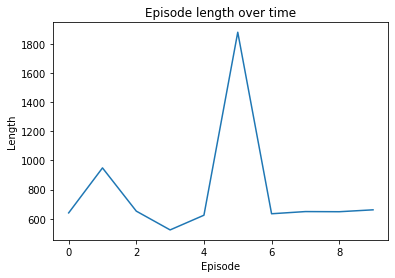

[15.0, 135.0, 15.0, 5.0, 50.0, 235.0, 15.0, 5.0, 40.0, 45.0]


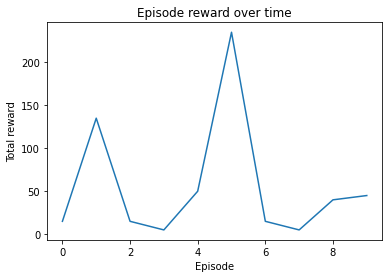

In [22]:
import matplotlib.pyplot as plt

plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
print(total_reward_episode[-100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

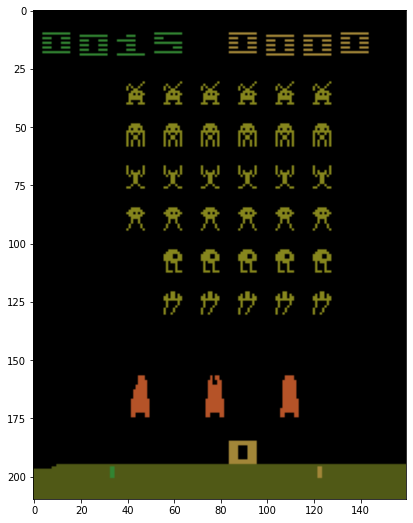

In [23]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(Q, available_actions):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    state = hash(tuple(state.reshape(-1)))
    while(not done):
        action = epsilon_greedy_policy(state, Q, available_actions)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state
        state = hash(tuple(state.reshape(-1)))

play_game(optimal_Q, available_actions)
env.close()

## Deep Q-Learning

A deep Q-Network (DQN) is similar to a supervised regression model $F_{\theta}$, but it more specifically maps states to action values directly instead of using a set of features.

A DQN is trained to output $Q(s,a)$ values for each action given the input state $s$. In operation, in state $s$, the action $a$ is chosen greedily based on $Q(s,a)$ or stochastically
following an epsilon-greedy policy.

<img src="img/RL2_DQN.png" title="DQN" style="width: 800px;" />

In tabular Q learning, the update rule is an off-policy TD learning rule. When we take
action $a$ in state $s$ receiving reward $r$, we update $Q(s,a)$ as

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a)),$$

where
 - $s'$ is the resulting state after taking action $a$ in state $s$
 - $\max_{a'}Q(s',a')$ is value of the action $a'$ we would take in state $s'$ according to a greedy behavior policy.

A DQN does the same thing using backpropagation, minimizing inconsistencies in its $Q$ estimates. At each step, the difference
between the estimated value and the observed data from the subsequent step should be minimized, giving us a kind of regression
problem, for which a squared error loss function is appopriate, giving us a delta for the $a$th output of

$$\delta_a=r+\gamma\max_{a'}Q(s')_{a'}-Q(s)_{a}.$$

With an appropriate exploration strategy and learning rate, DQN should find the optimal network model best approximating
the state-value function $Q(s,a)$ for each possible state and action.

## DQN Example: Cartpole

Let's develop a sample DQN application step by step. First, some imports we'll need.
We'll use the `gym` package like last week.

In [24]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### $\epsilon$ decay schedule

Recall that some of the theoretical results on TD learning assume $\epsilon$-greedy exploration with $\epsilon$ decaying slowly to 0
over time. Let's define an exponential decay schedule for $\epsilon$. First, an example:


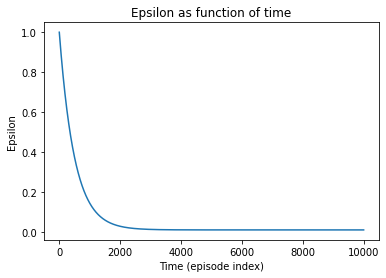

In [25]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()


Here's a reusable function to generate an annealing schedule function according to given parameters:

In [26]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

### Replay buffer

We know that deep learning methods learn faster when training samples are combined into batches. This speeds up learning and also makes it more stable by averaging
updates over multiple samaples.

RL algorithms also benefit from batched training. However, we see that the standard Q learning rule always updates $Q$ estimates using the most recent experience.
If we always trained on batches consisting of samples of the most recent behavior, correlations between successive state action pairs will make learning less effective.
So we would also like to select random training samples to make them look more like the i.i.d. sampling that supervised learning performs well under.

In RL, the standard way of doing this is to create a large buffer of past state action pairs then form training batches by sampling from that replay buffer.
Our replay buffer will store tuples consisting of an observed state, an action, the next_state, the reward, and the termination signal obtained by the agent at that point in time:

In [27]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Basic DQN

Next, a basic DQN class. We just create a neural network that takes as input a state
and returns an output vector indiciating the value of each possible action $Q(s,a)$.

The steps we take during learning will be as follows:

<img src="img/RL2_DQNstep.jpeg" title="" style="width: 600px;" />

To implement the policy, besides the usual `forward()` method, we add one additional method `act()`,
which samples an $\epsilon$-greedy action for state $s$ using the current estimate $Q(s,a)$.
`act()` will be used to implement step 1 in the pseudocode above.


In [28]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

### Create gym environment, prepare DQN for training

Next we set up a gym environment for the cartpole simulation, create a DQN model with Adam optimization, and create a replay buffer of length 1000.

In [29]:
env_id = "CartPole-v1"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

### Training step

In the training step, we sample a batch from the replay buffer, calculate $Q(s,a)$ and $\max_{a'} Q(s',a')$, calculate
the target $Q$ value $r + \gamma\max_{a'}Q(s',a')$, the mean squared loss between the predicted and target $Q$ values,
and then backpropagate.


In [30]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Plot rewards and losses

Here's a little function to plot relevant details for us:

In [31]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

### Training loop

The training loop lets the agent play the game until the end of the episode.
Each step is appended to the replay buffer. We don't do any learning until the buffer's length reaches the batch_size.


In [32]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done, _ = env.step(action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

### Train!

Let's train our DQN model for 10,000 steps in the cartpole simulation:

Agent training (episode5) Avg Reward 0.8:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/3771632107.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode10001) Avg Reward 0.9999000099990001: 100%|██████████| 10001/10001 [00:48<00:00, 206.56it/s]


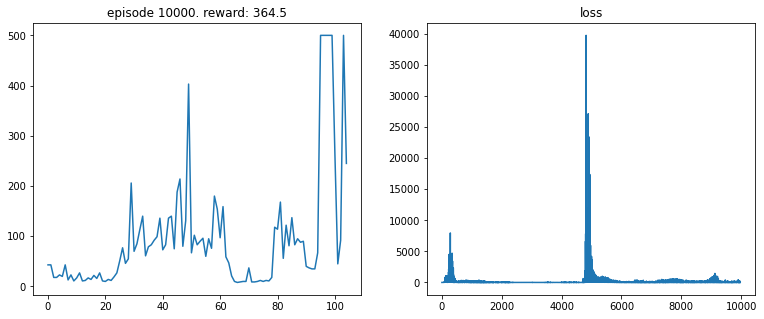

In [33]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

### Play in the simulation

You can run your simulation in Jupyter if you have OpenGL installed, but after the simulation is finished, you must close the
simulator with `env.close()` (this closes the simulator, not the environment).

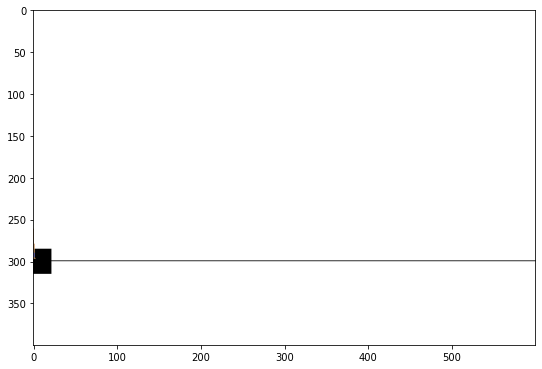

In [34]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(model):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state

play_game(model)
env.close()

### In class exercise (50 points)

Apply DQN to the CarRacing-v0 environment.
    

In [37]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [38]:
env_id = "CartPole-v1"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Agent training (episode21) Avg Reward 0.9523809523809523:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode33) Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/3771632107.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode10001) Avg Reward 0.9999000099990001: 100%|██████████| 10001/10001 [00:43<00:00, 228.19it/s]


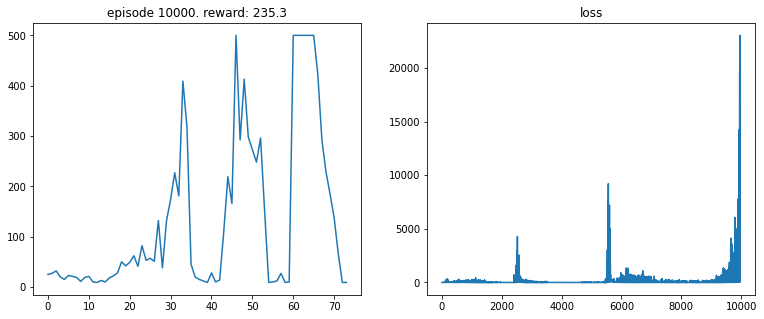

In [40]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

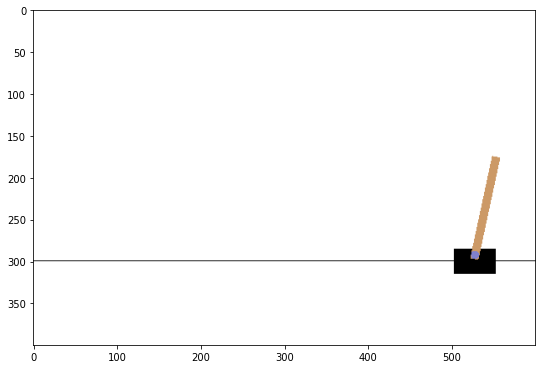

In [41]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(model):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state

play_game(model)
env.close()

### Take home exercise (50 points)

Apply DQN to Space Invaders. How well can you score?

In [42]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [43]:
env_id = "SpaceInvaders-v0"
env_SpaceInvaders = gym.make(env_id)
env_SpaceInvaders.reset()
n_state = env_SpaceInvaders.observation_space.shape[0]*env_SpaceInvaders.observation_space.shape[1]
n_state = env_SpaceInvaders.observation_space.shape[2]
model = DQN(n_state, env_SpaceInvaders.action_space.n).to(device)
print(n_state, env_SpaceInvaders.action_space.n)

optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

3 6


In [46]:
model,all_rewards, losses = train(env_SpaceInvaders, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

Agent training (episode6) Avg Reward 0.0:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode6) Avg Reward 0.0:   0%|          | 5/10001 [00:00<01:25, 116.28it/s]


ValueError: only one element tensors can be converted to Python scalars

Agent training (episode13) Avg Reward 0.0:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_4900/2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode13) Avg Reward 0.0:   0%|          | 12/10001 [00:00<01:05, 152.65it/s]


ValueError: only one element tensors can be converted to Python scalars